# 04 - Train Model

In [41]:
# imports
import os
import warnings
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Bidirectional, GRU, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Nadam

# Disable GPU usage (if not using GPU)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Suppress all TensorFlow logs and CUDA warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Only show errors
warnings.filterwarnings("ignore", category=UserWarning, module="tensorflow")

# Set TensorFlow log level to ERROR (to suppress info and warnings)
tf.get_logger().setLevel('ERROR')

# notebook settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [9]:
data = pd.read_csv(os.path.join('..','data','processed','data_for_model.csv'))

print(data.shape)

data.head()

(7429, 95)


,home_team,away_team,full_time_result,day_of_week,month,day_of_week_sin,day_of_week_cos,month_sin,month_cos,home_roll_3_avg_home_total_goals,away_roll_3_avg_home_total_goals,home_roll_3_avg_away_total_goals,away_roll_3_avg_away_total_goals,home_roll_3_avg_home_total_shots,away_roll_3_avg_home_total_shots,home_roll_3_avg_away_total_shots,away_roll_3_avg_away_total_shots,home_roll_3_avg_home_shots_on_target,away_roll_3_avg_home_shots_on_target,home_roll_3_avg_away_shots_on_target,away_roll_3_avg_away_shots_on_target,home_roll_3_avg_home_fouls,away_roll_3_avg_home_fouls,home_roll_3_avg_away_fouls,away_roll_3_avg_away_fouls,home_roll_3_avg_home_corners,away_roll_3_avg_home_corners,home_roll_3_avg_away_corners,away_roll_3_avg_away_corners,home_roll_3_avg_home_yellow_cards,away_roll_3_avg_home_yellow_cards,home_roll_3_avg_away_yellow_cards,away_roll_3_avg_away_yellow_cards,home_roll_3_avg_home_red_cards,away_roll_3_avg_home_red_cards,home_roll_3_avg_away_red_cards,away_roll_3_avg_away_red_cards,home_roll_3_avg_home_shot_accuracy,away_roll_3_avg_home_shot_accuracy,home_roll_3_avg_away_shot_accuracy,away_roll_3_avg_away_shot_accuracy,home_roll_3_avg_ratio_h_a_shots,away_roll_3_avg_ratio_h_a_shots,home_roll_3_avg_ratio_h_a_fouls,away_roll_3_avg_ratio_h_a_fouls,home_roll_3_avg_ratio_a_h_shots,away_roll_3_avg_ratio_a_h_shots,home_roll_3_avg_ratio_a_h_fouls,away_roll_3_avg_ratio_a_h_fouls,home_roll_3_avg_goal_difference,away_roll_3_avg_goal_difference,home_roll_5_avg_home_total_goals,away_roll_5_avg_home_total_goals,home_roll_5_avg_away_total_goals,away_roll_5_avg_away_total_goals,home_roll_5_avg_home_total_shots,away_roll_5_avg_home_total_shots,home_roll_5_avg_away_total_shots,away_roll_5_avg_away_total_shots,home_roll_5_avg_home_shots_on_target,away_roll_5_avg_home_shots_on_target,home_roll_5_avg_away_shots_on_target,away_roll_5_avg_away_shots_on_target,home_roll_5_avg_home_fouls,away_roll_5_avg_home_fouls,home_roll_5_avg_away_fouls,away_roll_5_avg_away_fouls,home_roll_5_avg_home_corners,away_roll_5_avg_home_corners,home_roll_5_avg_away_corners,away_roll_5_avg_away_corners,home_roll_5_avg_home_yellow_cards,away_roll_5_avg_home_yellow_cards,home_roll_5_avg_away_yellow_cards,away_roll_5_avg_away_yellow_cards,home_roll_5_avg_home_red_cards,away_roll_5_avg_home_red_cards,home_roll_5_avg_away_red_cards,away_roll_5_avg_away_red_cards,home_roll_5_avg_home_shot_accuracy,away_roll_5_avg_home_shot_accuracy,home_roll_5_avg_away_shot_accuracy,away_roll_5_avg_away_shot_accuracy,home_roll_5_avg_ratio_h_a_shots,away_roll_5_avg_ratio_h_a_shots,home_roll_5_avg_ratio_h_a_fouls,away_roll_5_avg_ratio_h_a_fouls,home_roll_5_avg_ratio_a_h_shots,away_roll_5_avg_ratio_a_h_shots,home_roll_5_avg_ratio_a_h_fouls,away_roll_5_avg_ratio_a_h_fouls,home_roll_5_avg_goal_difference,away_roll_5_avg_goal_difference,home_cumulative_points,away_cumulative_points
0,aston villa,bolton,D,5,8,-0.866025,0.5,-0.866025,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
1,everton,man united,A,5,8,-0.866025,0.5,-0.866025,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3
2,fulham,birmingham,D,5,8,-0.866025,0.5,-0.866025,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [10]:
print(data.shape)
data.columns

(7429, 95)


Index(['home_team', 'away_team', 'full_time_result', 'day_of_week', 'month',
       'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
       'home_roll_3_avg_home_total_goals', 'away_roll_3_avg_home_total_goals',
       'home_roll_3_avg_away_total_goals', 'away_roll_3_avg_away_total_goals',
       'home_roll_3_avg_home_total_shots', 'away_roll_3_avg_home_total_shots',
       'home_roll_3_avg_away_total_shots', 'away_roll_3_avg_away_total_shots',
       'home_roll_3_avg_home_shots_on_target',
       'away_roll_3_avg_home_shots_on_target',
       'home_roll_3_avg_away_shots_on_target',
       'away_roll_3_avg_away_shots_on_target', 'home_roll_3_avg_home_fouls',
       'away_roll_3_avg_home_fouls', 'home_roll_3_avg_away_fouls',
       'away_roll_3_avg_away_fouls', 'home_roll_3_avg_home_corners',
       'away_roll_3_avg_home_corners', 'home_roll_3_avg_away_corners',
       'away_roll_3_avg_away_corners', 'home_roll_3_avg_home_yellow_cards',
       'away_roll_3_avg_home_yellow

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7429 entries, 0 to 7428
Data columns (total 95 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   home_team                             7429 non-null   object 
 1   away_team                             7429 non-null   object 
 2   full_time_result                      7429 non-null   object 
 3   day_of_week                           7429 non-null   int64  
 4   month                                 7429 non-null   int64  
 5   day_of_week_sin                       7429 non-null   float64
 6   day_of_week_cos                       7429 non-null   float64
 7   month_sin                             7429 non-null   float64
 8   month_cos                             7429 non-null   float64
 9   home_roll_3_avg_home_total_goals      7429 non-null   float64
 10  away_roll_3_avg_home_total_goals      7429 non-null   float64
 11  home_roll_3_avg_a

In [12]:
# define X and y
X = data.drop(columns=['full_time_result'])
y = data['full_time_result']

In [13]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5943, 94), (1486, 94), (5943,), (1486,))

In [14]:
def plot_training_history(history, name):
    plt.figure(figsize=(12, 6))

    # Plot Training and Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss ({name})')  # Title with model name
    plt.legend()

    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Training and Validation Accuracy ({name})')  # Title with model name
    plt.legend()

    plt.tight_layout()

    # Ensure the directory exists
    os.makedirs(os.path.join('..', 'images'), exist_ok=True)
    
    # Save the plot with the name as part of the filename
    plt.savefig(os.path.join('..','images', name + '.png'))
    
    plt.show()


## Preprocess Data

In [15]:
# Preprocessing Function
def preprocess_data(X, y):
    # Identify categorical and numerical features
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()
    numerical_features = list(X.drop(columns=categorical_features).columns)
    
    # Preprocess categorical and numerical features
    ct = ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ])
    X_processed = ct.fit_transform(X)
    
    # Encode target variable ('H', 'D', 'A')
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)  # Converts 'H', 'D', 'A' to 0, 1, 2
    y_categorical = to_categorical(y_encoded)  # One-hot encoding
    
    return X_processed, y_categorical, ct, label_encoder

# Preprocess the data
X_train_processed, y_train_processed, ct, label_encoder = preprocess_data(X_train, y_train)
X_test_processed = ct.transform(X_test)
y_test_encoded = label_encoder.transform(y_test)
y_test_processed = to_categorical(y_test_encoded)

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))  # Convert to dict for Keras

## Model Testing

In [16]:
# Define a learning rate schedule function
def lr_schedule(epoch, lr):
    if epoch < 10:
        return float(lr)  # Ensuring that the returned value is a plain float
    else:
        # Use exponential decay to reduce the learning rate
        new_lr = float(lr * tf.math.exp(-0.1))  # Convert Tensor to Python float
        return new_lr
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

### Dense Model

In [17]:
# Build the refined Dense Model
model_dense = Sequential([
    Input(shape=(X_train_processed.shape[1],)),
    Dense(128, activation='swish', kernel_regularizer=l2(0.005)),  # Changed activation to 'swish' and regularization strength
    Dropout(0.4),
    Dense(64, activation='swish', kernel_regularizer=l2(0.005)),
    Dropout(0.4),
    Dense(3, activation='softmax')
])

# Compile the model with adjusted learning rate scheduler
optimizer = Adam(learning_rate=0.001)
model_dense.compile(optimizer=optimizer,
                             loss='categorical_crossentropy',
                             metrics=['accuracy'])

# Train the refined model with the fixed learning rate scheduler
history_dense = model_dense.fit(X_train_processed, y_train_processed,
                                                  epochs=100,
                                                  batch_size=32,
                                                  validation_split=0.2,
                                                  verbose=1,
                                                  class_weight=class_weights,
                                                  callbacks=[early_stopping, LearningRateScheduler(lr_schedule)])

# Evaluate the refined model
test_loss_dense, test_accuracy_dense = model_dense.evaluate(X_test_processed, y_test_processed)
print(f"Dense Model Test Accuracy: {test_accuracy_dense:.2f}")

Epoch 1/100


2025-01-18 22:48:48.469115: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3940 - loss: 2.1100 - val_accuracy: 0.4617 - val_loss: 1.6064 - learning_rate: 0.0010
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4929 - loss: 1.5298 - val_accuracy: 0.5198 - val_loss: 1.3515 - learning_rate: 0.0010
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5411 - loss: 1.3078 - val_accuracy: 0.5786 - val_loss: 1.2023 - learning_rate: 0.0010
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5801 - loss: 1.1787 - val_accuracy: 0.6081 - val_loss: 1.0918 - learning_rate: 0.0010
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5906 - loss: 1.0901 - val_accuracy: 0.5879 - val_loss: 1.0449 - learning_rate: 0.0010
Epoch 6/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5884 - loss: 1.0473 - val_accuracy: 0.5660 - val_loss: 1.0130 - learning_rate: 0.0010
Epoch 7/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6132 - loss: 1.0117 - val_a

In [18]:
# save the model
path_to_save_model = os.path.join('..','models','model_dense.keras')

model_dense.save(path_to_save_model)

# how many MB the model is
os.path.getsize(path_to_save_model) / (1024 * 1024)  # in MB

0.3903999328613281

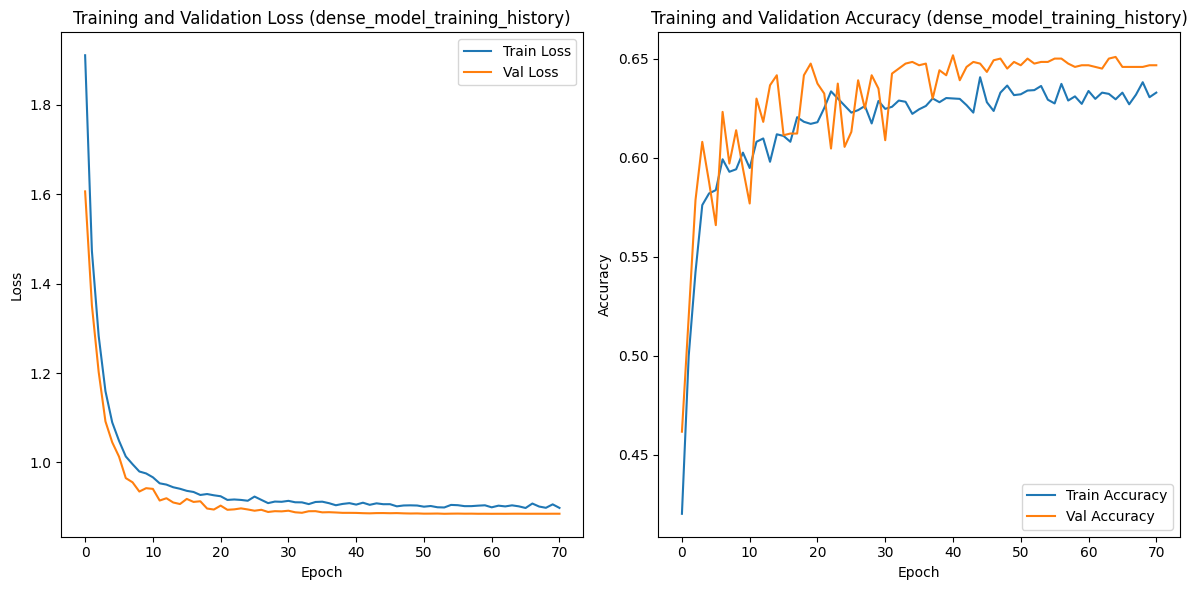

In [19]:
# Call the function to plot the training history
plot_training_history(history_dense, name='dense_model_training_history')

### Convolutional Neural Network (CNN)

- If your dataset has features that can be spatially correlated or you can convert categorical features into embeddings, CNNs can help detect patterns.

Key Idea:
- Use 1D convolutions to extract features from the data.

In [ ]:
model_cnn = Sequential([
    Input(shape=(X_train_processed.shape[1], 1)),
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001)),  # Smaller filters
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.3),
    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001)),  # Smaller filters
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.3),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

# Compile the refined CNN model
model_cnn.compile(optimizer=Adam(learning_rate=0.001),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

# Train the refined CNN model
history_cnn = model_cnn.fit(X_train_processed[..., np.newaxis],
                                              y_train_processed,
                                              epochs=100,
                                              batch_size=32,
                                              validation_split=0.2,
                                              class_weight=class_weights,
                                              callbacks=[early_stopping, LearningRateScheduler(lr_schedule)])

# Evaluate the refined CNN model
cnn_test_loss, cnn_test_accuracy = model_cnn.evaluate(X_test_processed[..., np.newaxis], y_test_processed)
print(f"CNN Model Test Accuracy: {cnn_test_accuracy:.2f}")

Epoch 1/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.3437 - loss: 1.3390 - val_accuracy: 0.4205 - val_loss: 1.2726 - learning_rate: 0.0010
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.3653 - loss: 1.2718 - val_accuracy: 0.2742 - val_loss: 1.2722 - learning_rate: 0.0010
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3860 - loss: 1.2366 - val_accuracy: 0.3036 - val_loss: 1.2269 - learning_rate: 0.0010
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4087 - loss: 1.2122 - val_accuracy: 0.4163 - val_loss: 1.1839 - learning_rate: 0.0010
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4109 - loss: 1.1852 - val_accuracy: 0.4659 - val_loss: 1.1536 - learning_rate: 0.0010
Epoch 6/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4336 - loss: 1.1612 - val_accuracy: 0.4609 - val_loss: 1.1394 - learning_rate: 0.0010
Epoch 7/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4376 - l

In [21]:
# save the model
path_to_save_model_cnn = os.path.join('..','models','model_cnn.keras')

model_cnn.save(path_to_save_model_cnn)

# how many MB the model is
os.path.getsize(path_to_save_model_cnn) / (1024 * 1024)  # in MB

0.538665771484375

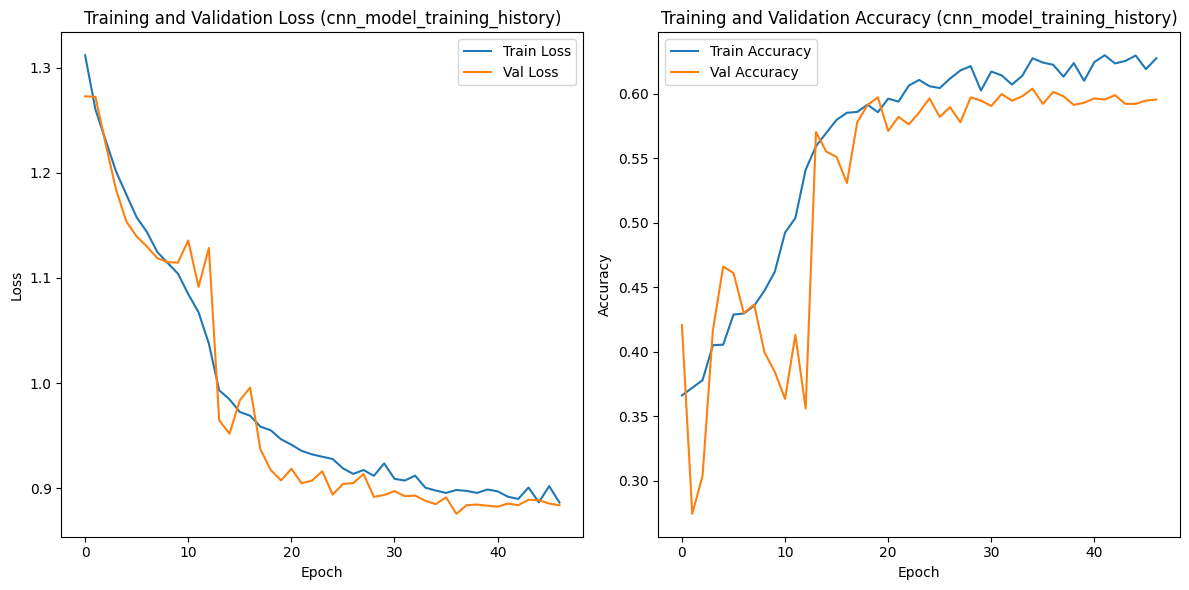

In [22]:
plot_training_history(history_cnn, name='cnn_model_training_history')

### Long Short-Term Memory (LSTM)

- LSTMs are effective for sequential data. If your dataset contains time-series features (e.g., match progression or historical performance)LSTMs can be beneficial.

Key Idea:
- Transform the input data into sequences to leverage temporal dependencies.

In [23]:
# Reshape data for LSTM (assuming sequences of fixed length)
sequence_length = 5  # For example, using sequences of 5 matches
X_train_seq = X_train_processed.reshape((-1, sequence_length, X_train_processed.shape[1] // sequence_length))
X_test_seq = X_test_processed.reshape((-1, sequence_length, X_test_processed.shape[1] // sequence_length))

# Build the LSTM model with improvements
model_lstm = Sequential([
    Input(shape=(sequence_length, X_train_seq.shape[2])),
    
    # Bidirectional LSTM layer
    Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer=l2(0.01))),
    BatchNormalization(),  # Batch normalization after LSTM layer
    Dropout(0.5),
    
    # Additional LSTM layer
    LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01)),
    BatchNormalization(),  # Batch normalization
    Dropout(0.5),
    
    # Final LSTM layer
    LSTM(64, kernel_regularizer=l2(0.01)),
    BatchNormalization(),  # Batch normalization
    Dropout(0.5),
    
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),  # Dense layer with regularization
    Dropout(0.5),  # Dropout for regularization
    Dense(3, activation='softmax')  # Output layer
])

# Compile the model
model_lstm.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Train the LSTM model
history_lstm = model_lstm.fit(
    X_train_seq,
    y_train_processed,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[early_stopping, LearningRateScheduler(lr_schedule)]
)

# Evaluate LSTM model
lstm_test_loss, lstm_test_accuracy = model_lstm.evaluate(X_test_seq, y_test_processed)
print(f"LSTM Test Accuracy: {lstm_test_accuracy:.2f}")

Epoch 1/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.3547 - loss: 9.7108 - val_accuracy: 0.4281 - val_loss: 6.5364 - learning_rate: 0.0010
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.4038 - loss: 6.0031 - val_accuracy: 0.4323 - val_loss: 4.1717 - learning_rate: 0.0010
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.4293 - loss: 3.8968 - val_accuracy: 0.4811 - val_loss: 2.8694 - learning_rate: 0.0010
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.4851 - loss: 2.7184 - val_accuracy: 0.5164 - val_loss: 2.1206 - learning_rate: 0.0010
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.5077 - loss: 2.0595 - val_accuracy: 0.5181 - val_loss: 1.6937 - learning_rate: 0.0010
Epoch 6/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5319 - loss: 1.6802 - val_accuracy: 0.5450 - val_loss: 1.4149 - learning_rate: 0.0010
Epoch 7/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s -2097468us/step - accuracy: 0.5

In [24]:
# save the model
path_to_save_model_lstm = os.path.join('..','models','model_lstm.keras')

model_lstm.save(path_to_save_model_lstm)

# how many MB the model is
os.path.getsize(path_to_save_model_lstm) / (1024 * 1024)  # in MB

11.389370918273926

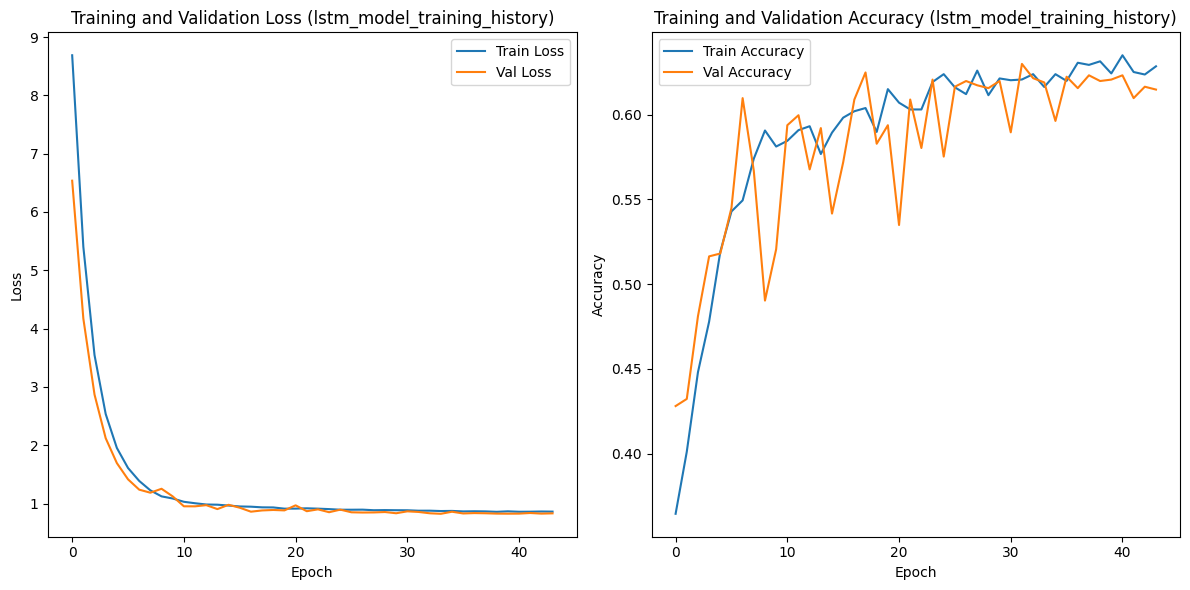

In [25]:
plot_training_history(history_lstm, name='lstm_model_training_history')

### Ensemble Learning

In [26]:
# Predict with each model
dense_predictions = model_dense.predict(X_test_processed)
cnn_predictions = model_cnn.predict(X_test_processed[..., np.newaxis])
lstm_predictions = model_lstm.predict(X_test_seq)

# Average the predictions (soft voting)
ensemble_predictions = (dense_predictions + cnn_predictions + lstm_predictions) / 3
ensemble_predictions = np.argmax(ensemble_predictions, axis=1)

# Evaluate ensemble model
ensemble_accuracy = accuracy_score(np.argmax(y_test_processed, axis=1), ensemble_predictions)
print(f"Ensemble Model Accuracy: {ensemble_accuracy:.2f}")


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Ensemble Model Accuracy: 0.65


# Hyperparameter Tuning

## Hyperparameter Tuning for Dense Model

In [42]:
# Define custom Keras model wrapper
class KerasModelWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, build_fn=None, optimizer='adam', dropout_rate=0.5, regularizer_l2=0.01, 
                 units=128, learning_rate=0.001, epochs=10, batch_size=32, sparse_labels=True, 
                 early_stopping=True, activation='swish', num_layers=2):
        self.build_fn = build_fn
        self.optimizer = optimizer
        self.dropout_rate = dropout_rate
        self.regularizer_l2 = regularizer_l2
        self.units = units
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.sparse_labels = sparse_labels
        self.early_stopping = early_stopping
        self.activation = activation
        self.num_layers = num_layers

    def fit(self, X, y):
        # Build the model
        self.model = self.build_fn(optimizer=self.optimizer, dropout_rate=self.dropout_rate,
                                   regularizer_l2=self.regularizer_l2, units=self.units, learning_rate=self.learning_rate,
                                   activation=self.activation, num_layers=self.num_layers)
        
        # EarlyStopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
        
        # Learning Rate Scheduler callback
        lr_scheduler = LearningRateScheduler(self.lr_schedule)
        
        # TensorBoard callback
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)
        
        # Initialize the callbacks list
        callbacks = [lr_scheduler, tensorboard]  # Initialize with the scheduler and TensorBoard
        
        # Include early stopping if enabled
        if self.early_stopping:
            callbacks.append(early_stopping)
        
        # Fit the model with appropriate callbacks
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=1, 
                       validation_split=0.2, callbacks=callbacks)
        return self

    def predict(self, X):
        return np.argmax(self.model.predict(X), axis=-1)

    def predict_proba(self, X):
        return self.model.predict(X)
    
    def lr_schedule(self, epoch, lr):
        if epoch < 10:
            return float(lr)  # Ensuring that the returned value is a plain float
        else:
            # Use exponential decay to reduce the learning rate
            new_lr = float(lr * tf.math.exp(-0.1))  # Convert Tensor to Python float
            return new_lr

# Function to create the Keras model
def create_dense_model(optimizer='adam', dropout_rate=0.5, regularizer_l2=0.01, units=128, learning_rate=0.001, activation='relu', num_layers=2):
    model = Sequential([Input(shape=(X_train_processed.shape[1],))])

    # Adding hidden layers with adjustable units, activation function, and dropout
    for _ in range(num_layers):
        model.add(Dense(units, activation=activation, kernel_regularizer=l2(regularizer_l2)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(3, activation='softmax'))  # Output layer for 3 classes

    model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Ensure labels are integer-encoded for sparse_categorical_crossentropy
y_train_processed_int = np.argmax(y_train_processed, axis=1)

# Adjust hyperparameters and re-run Bayesian Search
param_space = {
    'dropout_rate': Real(0.2, 0.5),  # A reasonable range for regularization with dropout
    'regularizer_l2': Real(1e-5, 0.1, 'log-uniform'),  # Regularization range to avoid overfitting, using log scale
    'units': Integer(64, 256),  # A balanced number of units for the layers
    'learning_rate': Real(1e-5, 1e-2, 'log-uniform'),  # Learning rate is crucial, and the log-uniform is appropriate
    'batch_size': Categorical([32, 64]),  # Typical batch sizes, 128 might be too large for small datasets
    'num_layers': Integer(2, 4),  # Testing between 2 and 4 layers; more layers will increase complexity
}

# Initialize Bayesian search with the custom Keras model wrapper
model_dense_bayes = KerasModelWrapper(build_fn=create_dense_model, sparse_labels=True)

# Initialize BayesSearchCV with updated suggestions
bayes_search = BayesSearchCV(
    model_dense_bayes,
    param_space,
    n_iter=10,  # Number of iterations to explore the hyperparameter space
    cv=3,  # Use 5-fold cross-validation
    n_jobs=-1,  # Use all available cores
    verbose=1,  # Print out messages during search
    scoring='accuracy'
)

# Fit the model with Bayesian optimization
bayes_search.fit(X_train_processed, y_train_processed_int)

# Print the best result
print(f"Best score: {bayes_search.best_score_}")
print(f"Best parameters: {bayes_search.best_params_}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits


2025-01-18 23:23:25.845280: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-18 23:23:25.852519: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-18 23:23:25.853871: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737242605.860639  682716 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737242605.865188  682716 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:17372

Epoch 1/10
Epoch 1/10
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.4803 - loss: 1.0548 - val_accuracy: 0.5132 - val_loss: 1.0080 - learning_rate: 0.0010
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.4821 - loss: 1.0462 - val_accuracy: 0.5296 - val_loss: 1.0055 - learning_rate: 0.0010
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.4799 - loss: 1.0722 - val_accuracy: 0.5296 - val_loss: 0.9918 - learning_rate: 0.0010
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5537 - loss: 0.9710 - val_accuracy: 0.5561 - val_loss: 0.9566 - learning_rate: 0.0010
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5621 - loss: 0.9653 - val_accuracy: 0.5612 - val_loss: 0.9680 - learning_rate: 0.0010
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5626 - loss: 0.9679 - val_accuracy: 0.5511 - val_loss: 0.9614 - learning_rate: 0.0010
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy:

2025-01-18 23:23:44.239573: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737242624.253593  682720 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737242624.258105  682720 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-18 23:23:44.316213: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737242624.329756  682726 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737242624.333435  682726 cuda_blas.cc:1

Epoch 1/10
Epoch 1/10
Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4507 - loss: 1.0948 - val_accuracy: 0.5032 - val_loss: 1.0481 - learning_rate: 0.0010
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4252 - loss: 1.1102 - val_accuracy: 0.5208 - val_loss: 1.0577 - learning_rate: 0.0010
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4619 - loss: 1.0886 - val_accuracy: 0.5586 - val_loss: 1.0082 - learning_rate: 0.0010
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5279 - loss: 1.0299 - val_accuracy: 0.5448 - val_loss: 1.0243 - learning_rate: 0.0010
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5325 - loss: 1.0229 - val_accuracy: 0.5296 - val_loss: 1.0093 - learning_rate: 0.0010
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5310 - loss: 1.0110 - val_accuracy: 0.5889 - val_loss: 0.9890 - learning_rate: 0.0010
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5712 - loss

2025-01-18 23:23:54.099846: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737242634.114295  684607 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737242634.118288  684607 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4436 - loss: 1.2747 - val_accuracy: 0.4805 - val_loss: 1.2288 - learning_rate: 0.0010
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4544 - loss: 1.2723 - val_accuracy: 0.5271 - val_loss: 1.1962 - learning_rate: 0.0010
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5219 - loss: 1.1843 - val_accuracy: 0.5233 - val_loss: 1.1746 - learning_rate: 0.0010
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5253 - loss: 1.1852 - val_accuracy: 0.5422 - val_loss: 1.1607 - learning_rate: 0.0010
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5602 - loss: 1.1396 - val_accuracy: 0.5624 - val_loss: 1.1373 - learning_rate: 0.0010
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5776 - loss: 1.1101 - val_accuracy: 0.6053 - val_loss: 1.1087 - learning_rate: 0.0010
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6039 - loss: 1.0626 - val_accuracy: 0.5549 - 

2025-01-18 23:29:11.029093: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6465 - loss: 0.9754 - val_accuracy: 0.5914 - val_loss: 1.0477 - learning_rate: 0.0010
Epoch 8/10
16/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6543 - loss: 0.9372 Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6378 - loss: 0.9823 - val_accuracy: 0.6053 - val_loss: 1.0533 - learning_rate: 0.0010
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6463 - loss: 0.9458 - val_accuracy: 0.5889 - val_loss: 1.0288 - learning_rate: 0.0010
Epoch 9/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6403 - loss: 0.9552 - val_accuracy: 0.6141 - val_loss: 1.0493 - learning_rate: 0.0010
Epoch 9/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6315 - loss: 0.9502 - val_accuracy: 0.5687 - val_loss: 1.0444 - learning_rate: 0.0010
Epoch 10/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6387 - loss: 0.9433 - val_accuracy: 0.6230 - val_loss: 1.0350 - learning_rate: 0.0010
Epoch 10/10
50/50 ━━━━━━━━

2025-01-18 23:29:22.912283: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-18 23:29:22.920425: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737242962.924865  688285 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737242962.931437  688285 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1737242962.940443  688286 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737242962.946445  688286 cuda_blas.cc:1

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4422 - loss: 1.1699 - val_accuracy: 0.4918 - val_loss: 1.1216 - learning_rate: 0.0010
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5171 - loss: 1.0892 - val_accuracy: 0.5107 - val_loss: 1.0884 - learning_rate: 0.0010
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5701 - loss: 1.0351 - val_accuracy: 0.5549 - val_loss: 1.0580 - learning_rate: 0.0010
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5945 - loss: 0.9962 - val_accuracy: 0.5662 - val_loss: 1.0297 - learning_rate: 0.0010
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6199 - loss: 0.9444 - val_accuracy: 0.5939 - val_loss: 1.0054 - learning_rate: 0.0010
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6374 - loss: 0.9142 - val_accuracy: 0.5612 - val_loss: 1.0120 - learning_rate: 0.0010
Epoch 7/10
 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5938 - loss: 0.9552

2025-01-18 23:24:11.369673: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-01-18 23:24:11.438798: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ -314s -6405767us/step - accuracy: 0.6300 - loss: 0.9157 - val_accuracy: 0.5864 - val_loss: 0.9760 - learning_rate: 0.0010
Epoch 8/10
Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6427 - loss: 0.8968 - val_accuracy: 0.5952 - val_loss: 0.9835 - learning_rate: 0.0010
Epoch 9/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6398 - loss: 0.8895 - val_accuracy: 0.5990 - val_loss: 0.9690 - learning_rate: 0.0010
Epoch 10/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6694 - loss: 0.8369 - val_accuracy: 0.5952 - val_loss: 0.9757 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 9.
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4152 - loss: 1.1966 - val_accuracy: 0.5158 - val_loss: 1.1242 - learning_rate: 0.0010
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4539 - loss: 1.1758 - val_accuracy: 0.5675 - val_loss: 1.0912 - learning_rat

2025-01-18 23:24:17.799053: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737242657.812323  688289 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737242657.815931  688289 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-18 23:24:17.825546: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-18 23:24:17.837269: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:17372

Epoch 1/10
Epoch 1/10
Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3779 - loss: 34.1446 - val_accuracy: 0.4401 - val_loss: 11.4005 - learning_rate: 0.0010
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4057 - loss: 33.8435 - val_accuracy: 0.4691 - val_loss: 11.2536 - learning_rate: 0.0010
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3881 - loss: 33.9178 - val_accuracy: 0.4401 - val_loss: 11.3066 - learning_rate: 0.0010
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4648 - loss: 8.2910 - val_accuracy: 0.4401 - val_loss: 2.8277 - learning_rate: 0.0010
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4561 - loss: 8.1977 - val_accuracy: 0.4691 - val_loss: 2.7738 - learning_rate: 0.0010
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4551 - loss: 8.2292 - val_accuracy: 0.4401 - val_loss: 2.8057 - learning_rate: 0.0010
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.47

2025-01-18 23:24:28.307708: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737242668.322060  688290 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-18 23:24:28.324049: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737242668.326758  688290 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-18 23:24:28.329800: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:17372

Epoch 1/10
Epoch 1/10
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ -312s 7ms/step - accuracy: 0.4431 - loss: 1.1316 - val_accuracy: 0.4893 - val_loss: 1.0693 - learning_rate: 0.0010
100/100 ━━━━━━━━━━━━━━━━━━━━ -312s 7ms/step - accuracy: 0.4509 - loss: 1.1158 - val_accuracy: 0.5334 - val_loss: 1.0210 - learning_rate: 0.0010
Epoch 2/10
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ -312s 7ms/step - accuracy: 0.4135 - loss: 1.1626 - val_accuracy: 0.4830 - val_loss: 1.0519 - learning_rate: 0.0010
  1/100 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5625 - loss: 0.9988Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5117 - loss: 1.0525 - val_accuracy: 0.5183 - val_loss: 1.0261 - learning_rate: 0.0010
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5507 - loss: 0.9936 - val_accuracy: 0.5637 - val_loss: 0.9997 - learning_rate: 0.0010
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5453 - loss: 1.0172 - val_accuracy: 0.5246 - val_loss: 1.0259 - lear

2025-01-18 23:29:59.104471: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737242999.117587  695640 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737242999.121263  695640 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4488 - loss: 1.0685 - val_accuracy: 0.4981 - val_loss: 1.0142 - learning_rate: 0.0010
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4336 - loss: 1.0658 - val_accuracy: 0.5397 - val_loss: 0.9860 - learning_rate: 0.0010
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5442 - loss: 0.9875 - val_accuracy: 0.5233 - val_loss: 0.9874 - learning_rate: 0.0010
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5361 - loss: 0.9717 - val_accuracy: 0.5473 - val_loss: 0.9731 - learning_rate: 0.0010
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5675 - loss: 0.9576 - val_accuracy: 0.5233 - val_loss: 0.9736 - learning_rate: 0.0010
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5673 - loss: 0.9379 - val_accuracy: 0.5750 - val_loss: 0.9432 - learning_rate: 0.0010
Epoch 4/10
 85/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6039 - loss: 0.8908

2025-01-18 23:30:01.959692: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5994 - loss: 0.8910 - val_accuracy: 0.5561 - val_loss: 0.9360 - learning_rate: 0.0010
Epoch 5/10
 18/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6334 - loss: 0.8593 Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6056 - loss: 0.8886 - val_accuracy: 0.5523 - val_loss: 1.0001 - learning_rate: 0.0010
 36/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6184 - loss: 0.8686Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6214 - loss: 0.8637 - val_accuracy: 0.5599 - val_loss: 0.9291 - learning_rate: 0.0010
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6208 - loss: 0.8608 - val_accuracy: 0.5952 - val_loss: 0.9192 - learning_rate: 0.0010
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6364 - loss: 0.8313 - val_accuracy: 0.5725 - val_loss: 0.9009 - learning_rate: 0.0010
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6316 - loss: 0.8385 - val

2025-01-18 23:30:10.394560: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737243010.411307  697412 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737243010.415835  697412 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


50/50 ━━━━━━━━━━━━━━━━━━━━ -312s 14ms/step - accuracy: 0.4441 - loss: 1.0815 - val_accuracy: 0.4842 - val_loss: 1.0337 - learning_rate: 0.0010
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ -312s 15ms/step - accuracy: 0.4275 - loss: 1.0894 - val_accuracy: 0.4968 - val_loss: 1.0214 - learning_rate: 0.0010
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5221 - loss: 1.0145 - val_accuracy: 0.5334 - val_loss: 0.9993 - learning_rate: 0.0010
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4911 - loss: 1.0372 - val_accuracy: 0.5082 - val_loss: 0.9961 - learning_rate: 0.0010
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5610 - loss: 0.9781 - val_accuracy: 0.5511 - val_loss: 0.9675 - learning_rate: 0.0010
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5466 - loss: 0.9806 - val_accuracy: 0.5422 - val_loss: 0.9683 - learning_rate: 0.0010
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5790 - loss: 0.9286 - val_accuracy: 0

2025-01-18 23:24:59.259906: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6135 - loss: 0.8917 - val_accuracy: 0.5750 - val_loss: 0.9248 - learning_rate: 0.0010
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5843 - loss: 0.9030 - val_accuracy: 0.5460 - val_loss: 0.9369 - learning_rate: 0.0010
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6218 - loss: 0.8682 - val_accuracy: 0.5864 - val_loss: 0.9207 - learning_rate: 0.0010
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5900 - loss: 0.8830 - val_accuracy: 0.5700 - val_loss: 0.9171 - learning_rate: 0.0010
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6185 - loss: 0.8699 - val_accuracy: 0.5977 - val_loss: 0.9082 - learning_rate: 0.0010
44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6161 - loss: 0.8699Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6159 - loss: 0.8698 - val_accuracy: 0.5675 - val_loss: 0.9142 - learning_rate: 0.0010
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 

In [47]:
# Launch TensorBoard
#%tensorboard --logdir logs/fit

# terminal command to launch tensorboard
# tensorboard --logdir=logs/fit

# Prediction

In [48]:
best_model_dense = bayes_search.best_estimator_.model

best_model_dense.save(os.path.join('..','models','best_model_dense.keras'))

best_model_dense.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 125)            │        22,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 125)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 125)            │        15,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 125)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 125)            │        15,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 125)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 3)              │           378 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 163,511 (638.72 KB)

 Trainable params: 54,503 (212.90 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 109,008 (425.82 KB)

In [49]:
# load the model
best_model_dense = tf.keras.models.load_model(os.path.join('..','models','best_model_dense.keras'))


# Get the last match data
home_team = 'everton'
away_team = 'wolves'

home_team_data = data[(data['home_team'] == home_team) | (data['away_team'] == home_team)].tail(1)
away_team_data = data[(data['home_team'] == away_team) | (data['away_team'] == away_team)].tail(1)

combined_data = pd.concat([home_team_data, away_team_data])
X_new = combined_data.drop(columns=['full_time_result'])

# Preprocess
X_new_processed = ct.transform(X_new)

# Predict probabilities
y_pred = best_model_dense.predict(X_new_processed)

# Check classes in label encoder to verify the order
print("Classes in label encoder:", label_encoder.classes_)

# Predicted probabilities
print(f"Predicted probabilities for {home_team} vs {away_team}:")
print(f"Home Win: {y_pred[0][2]:.4f}")
print(f"Draw: {y_pred[0][1]:.4f}")
print(f"Away Win: {y_pred[0][0]:.4f}")

# Convert the probabilities to predicted class index
y_pred_classes = np.argmax(y_pred, axis=1)

# Correct the mapping based on your label encoder's class order
class_mapping = {0: 'A', 1: 'D', 2: 'H'}
predicted_label = class_mapping[y_pred_classes[0]]

# Print the final predicted result
print(f"Predicted full-time result for {home_team} vs {away_team}: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Classes in label encoder: ['A' 'D' 'H']
Predicted probabilities for everton vs wolves:
Home Win: 0.0731
Draw: 0.1703
Away Win: 0.7565
Predicted full-time result for everton vs wolves: A
